Valid image files: ['spleen_10.nii', 'spleen_12.nii', 'spleen_13.nii', 'spleen_14.nii', 'spleen_16.nii', 'spleen_17.nii', 'spleen_18.nii', 'spleen_19.nii', 'spleen_2.nii', 'spleen_20.nii', 'spleen_21.nii', 'spleen_22.nii', 'spleen_24.nii', 'spleen_25.nii', 'spleen_26.nii', 'spleen_27.nii', 'spleen_28.nii', 'spleen_29.nii', 'spleen_3.nii', 'spleen_31.nii', 'spleen_32.nii', 'spleen_33.nii', 'spleen_38.nii', 'spleen_40.nii', 'spleen_41.nii', 'spleen_44.nii', 'spleen_45.nii', 'spleen_46.nii', 'spleen_47.nii', 'spleen_49.nii', 'spleen_52.nii', 'spleen_53.nii', 'spleen_56.nii', 'spleen_59.nii', 'spleen_6.nii', 'spleen_60.nii', 'spleen_61.nii', 'spleen_62.nii', 'spleen_63.nii', 'spleen_8.nii', 'spleen_9.nii']
Valid label files: ['spleen_10.nii', 'spleen_12.nii', 'spleen_13.nii', 'spleen_14.nii', 'spleen_16.nii', 'spleen_17.nii', 'spleen_18.nii', 'spleen_19.nii', 'spleen_2.nii', 'spleen_20.nii', 'spleen_21.nii', 'spleen_22.nii', 'spleen_24.nii', 'spleen_25.nii', 'spleen_26.nii', 'spleen_27.nii

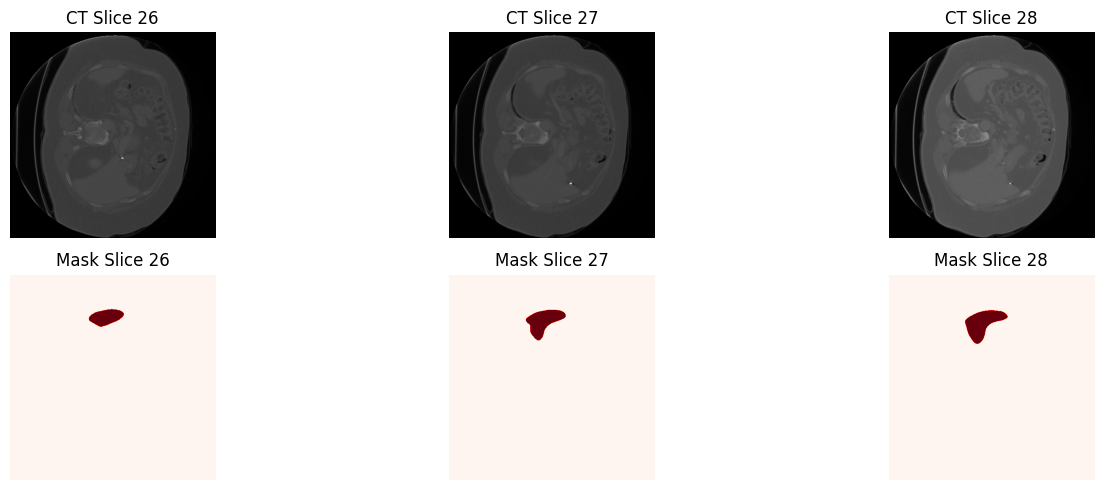

In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Define paths
data_path = "/kaggle/input/task9-spleen/Task09_Spleen"
images_dir = os.path.join(data_path, "imagesTr")
labels_dir = os.path.join(data_path, "labelsTr")

# Filter for only clean filenames (no spaces, no ._ files)
image_files = sorted([
    f for f in os.listdir(images_dir)
    if (f.endswith(".nii") or f.endswith(".nii.gz")) and not f.startswith("._") and ' ' not in f
])
label_files = sorted([
    f for f in os.listdir(labels_dir)
    if (f.endswith(".nii") or f.endswith(".nii.gz")) and not f.startswith("._") and ' ' not in f
])

print(f"Valid image files: {image_files}")
print(f"Valid label files: {label_files}")

# Use the first valid file
sample_image_path = os.path.join(images_dir, image_files[0])
sample_label_path = os.path.join(labels_dir, label_files[0])

# Load files
image_nifti = nib.load(sample_image_path)
label_nifti = nib.load(sample_label_path)

image = image_nifti.get_fdata()
label = label_nifti.get_fdata()

print(f"Image shape: {image.shape}, Label shape: {label.shape}")

# Visualize slices
def show_slices(image, label, indices):
    fig, axs = plt.subplots(2, len(indices), figsize=(15, 5))
    for i, idx in enumerate(indices):
        axs[0, i].imshow(image[:, :, idx], cmap='gray')
        axs[0, i].set_title(f"CT Slice {idx}")
        axs[0, i].axis("off")

        axs[1, i].imshow(label[:, :, idx], cmap='Reds')
        axs[1, i].set_title(f"Mask Slice {idx}")
        axs[1, i].axis("off")
    plt.tight_layout()
    plt.show()

# Show a few center slices
mid_index = image.shape[2] // 2
show_slices(image, label, [mid_index - 1, mid_index, mid_index + 1])


In [2]:
import os

data_path = "/kaggle/input/task9-spleen/Task09_Spleen"
images_dir = os.path.join(data_path, "imagesTr")
labels_dir = os.path.join(data_path, "labelsTr")

print("Image directory contents:")
print(os.listdir(images_dir))

print("\nLabel directory contents:")
print(os.listdir(labels_dir))


Image directory contents:
['spleen_53.nii', 'spleen_32.nii', '._spleen_22.nii.gz', 'spleen_20.nii', '._spleen_44.nii.gz', 'spleen_3.nii', '._spleen_24.nii.gz', 'spleen_61.nii', '._spleen_62.nii.gz', 'spleen_12.nii', '._spleen_13.nii.gz', '._spleen_26.nii.gz', '._spleen_10.nii.gz', 'spleen_21.nii', 'spleen_45.nii', '._spleen_32.nii.gz', '._spleen_47.nii.gz', '._spleen_2.nii.gz', 'spleen_2.nii', 'spleen_26.nii', 'spleen_52.nii', 'spleen_41.nii', '._spleen_29.nii.gz', '._spleen_59.nii.gz', '._spleen_60.nii.gz', '._spleen_27.nii.gz', '._spleen_9.nii.gz', '._spleen_53.nii.gz', 'spleen_9.nii', '._spleen_31.nii.gz', 'spleen_18.nii', 'spleen_56.nii', 'spleen_13.nii', 'spleen_29.nii', 'spleen_16.nii', '._spleen_17.nii.gz', 'spleen_46.nii', 'spleen_40.nii', '._spleen_40.nii.gz', 'spleen_59.nii', 'spleen_38.nii', 'spleen_25.nii', '._spleen_41.nii.gz', '._spleen_38.nii.gz', 'spleen_8.nii', '._spleen_12.nii.gz', '._spleen_45.nii.gz', 'spleen_27.nii', 'spleen_60.nii', 'spleen_31.nii', 'spleen_22.nii

In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.optim as optim
from sklearn.model_selection import train_test_split
from nibabel.filebasedimages import ImageFileError
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from tqdm import tqdm

# U-Net Implementation
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        
        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
        
        # Downsampling path
        self.dconv_down1 = double_conv(in_channels, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Upsampling path
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(64 + 128, 64)
        
        self.conv_last = nn.Conv2d(64, out_channels, 1)
        
    def forward(self, x):
        # Encoder
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)
        
        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        
        x = self.dconv_down4(x)
        
        # Decoder
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)
        
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)
        
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        return out

# Dataset Class with proper file handling
class SpleenDataset(Dataset):
    def __init__(self, image_dir, label_dir=None, transform=None, test_mode=False):
        self.test_mode = test_mode
        # Get all files in directories
        all_image_files = sorted(os.listdir(image_dir))
        
        # Filter out hidden files and keep both .nii and .nii.gz
        self.image_files = [
            f for f in all_image_files 
            if (f.endswith(".nii") or f.endswith(".nii.gz")) and not f.startswith("._")
        ]
        
        if not test_mode:
            all_label_files = sorted(os.listdir(label_dir))
            self.label_files = [
                f for f in all_label_files 
                if (f.endswith(".nii") or f.endswith(".nii.gz")) and not f.startswith("._")
            ]
            
            # Create mapping of base names to full filenames
            image_dict = {}
            for f in self.image_files:
                base = os.path.splitext(f)[0]
                if base.endswith('.nii'):  # Handle double extension case
                    base = os.path.splitext(base)[0]
                image_dict[base] = f
                
            label_dict = {}
            for f in self.label_files:
                base = os.path.splitext(f)[0]
                if base.endswith('.nii'):  # Handle double extension case
                    base = os.path.splitext(base)[0]
                label_dict[base] = f
            
            # Find common base names
            common_bases = set(image_dict.keys()) & set(label_dict.keys())
            
            # Create matched pairs
            self.image_files = [image_dict[base] for base in common_bases]
            self.label_files = [label_dict[base] for base in common_bases]
            
            print(f"Found {len(self.image_files)} valid image/label pairs")
            if len(self.image_files) > 0:
                print(f"First few pairs: {list(zip(self.image_files[:3], self.label_files[:3]))}")
        else:
            self.label_files = None
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.slices = []
        
        # Precompute valid slices
        for img_file in self.image_files:
            try:
                img_path = os.path.join(image_dir, img_file)
                
                if not os.path.exists(img_path):
                    print(f"Image file not found: {img_path}")
                    continue
                
                img_vol = nib.load(img_path).get_fdata()
                
                if not test_mode:
                    lbl_file = img_file  # Using same filename for labels
                    lbl_path = os.path.join(label_dir, lbl_file)
                    
                    if not os.path.exists(lbl_path):
                        print(f"Label file not found: {lbl_path}")
                        continue
                    
                    lbl = nib.load(lbl_path).get_fdata()
                    for i in range(lbl.shape[2]):
                        if lbl[:, :, i].sum() > 0:  # Only keep slices with spleen
                            self.slices.append((img_file, i))
                else:
                    # For test mode, include all slices
                    for i in range(img_vol.shape[2]):
                        self.slices.append((img_file, i))
                        
            except (ImageFileError, nib.filebasedimages.ImageFileError) as e:
                print(f"Skipping corrupt file: {img_file} - Error: {str(e)}")
                continue
    
    def __len__(self):
        return len(self.slices)
    
    def __getitem__(self, idx):
        img_file, slice_idx = self.slices[idx]
        img_path = os.path.join(self.image_dir, img_file)
        
        try:
            img_vol = nib.load(img_path).get_fdata()
            
            if not self.test_mode:
                lbl_path = os.path.join(self.label_dir, img_file)
                lbl_vol = nib.load(lbl_path).get_fdata()
                lbl_slice = lbl_vol[:, :, slice_idx]
                lbl = (lbl_slice > 0).astype(np.float32)
            else:
                lbl = np.zeros_like(img_vol[:, :, slice_idx])  # Dummy label for test
        except (ImageFileError, nib.filebasedimages.ImageFileError) as e:
            print(f"Error loading file: {img_file} - {str(e)}")
            # Return a random valid slice instead
            random_idx = np.random.randint(0, len(self))
            return self.__getitem__(random_idx)
            
        # Extract slice and adjacent slices
        img_slice = img_vol[:, :, slice_idx]
        
        # CT windowing (-100 to 400 HU for spleen)
        img_slice = np.clip(img_slice, -100, 400)
        img_slice = (img_slice - (-100)) / (400 - (-100))  # Normalize to [0,1]
        
        # Create 3-channel input using adjacent slices
        channels = []
        for offset in [-1, 0, 1]:
            s_idx = min(max(slice_idx + offset, 0), img_vol.shape[2] - 1)
            adj_slice = img_vol[:, :, s_idx]
            adj_slice = np.clip(adj_slice, -100, 400)
            adj_slice = (adj_slice - (-100)) / (400 - (-100))
            channels.append(adj_slice)
        img = np.stack(channels, axis=0)
        
        img_tensor = torch.tensor(img, dtype=torch.float32)
        lbl_tensor = torch.tensor(lbl, dtype=torch.float32).unsqueeze(0)
        
        if self.transform:
            seed = np.random.randint(2147483647)
            torch.manual_seed(seed)
            img_tensor = self.transform(img_tensor)
            if not self.test_mode:
                torch.manual_seed(seed)
                lbl_tensor = self.transform(lbl_tensor)
        
        if self.test_mode:
            return img_tensor, img_file, slice_idx
        return img_tensor, lbl_tensor

# Loss Functions
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum()
        union = pred.sum() + target.sum()
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super(CombinedLoss, self).__init__()
        self.bce_weight = bce_weight
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
    
    def forward(self, pred, target):
        return self.bce_weight * self.bce(pred, target) + (1 - self.bce_weight) * self.dice(pred, target)

def plot_sample(image, mask, pred=None, save_path=None):
    """Plot image, ground truth mask, and prediction"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3 if pred is not None else 2, 1)
    plt.imshow(image[0], cmap='gray')
    plt.title("Image Slice")
    plt.axis('off')
    
    plt.subplot(1, 3 if pred is not None else 2, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')
    
    if pred is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(pred.squeeze(), cmap='gray')
        plt.title("Prediction")
        plt.axis('off')
    
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

def evaluate_model(model, dataloader, device, criterion, save_dir=None):
    model.eval()
    val_loss = 0
    dice_scores = []
    precisions = []
    recalls = []
    f1_scores = []
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for i, (images, masks) in enumerate(tqdm(dataloader, desc="Evaluating")):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, masks).item()
            
            preds = torch.sigmoid(outputs) > 0.5
            preds_np = preds.cpu().numpy()
            masks_np = masks.cpu().numpy()
            
            # Calculate metrics per sample
            for pred, mask in zip(preds_np, masks_np):
                intersection = (pred * mask).sum()
                union = pred.sum() + mask.sum()
                dice = (2. * intersection) / (union + 1e-8)
                dice_scores.append(dice)
                
                # Flatten for other metrics
                pred_flat = pred.flatten()
                mask_flat = mask.flatten()
                
                precisions.append(precision_score(mask_flat, pred_flat, zero_division=0))
                recalls.append(recall_score(mask_flat, pred_flat, zero_division=0))
                f1_scores.append(f1_score(mask_flat, pred_flat, zero_division=0))
                
                all_preds.extend(pred_flat)
                all_targets.extend(mask_flat)
            
            # Save visualization for first batch
            if save_dir and i == 0:
                os.makedirs(save_dir, exist_ok=True)
                for j in range(min(3, images.size(0))):  # Save first 3 samples
                    plot_sample(
                        images[j].cpu().numpy(),
                        masks[j].cpu().numpy(),
                        preds[j].cpu().numpy(),
                        save_path=os.path.join(save_dir, f"sample_{i}_{j}.png")
                    )
    
    # Calculate confusion matrix
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    if save_dir:
        plt.savefig(os.path.join(save_dir, "confusion_matrix.png"))
        plt.close()
    else:
        plt.show()
    
    metrics = {
        'loss': val_loss / len(dataloader),
        'dice': np.mean(dice_scores),
        'precision': np.mean(precisions),
        'recall': np.mean(recalls),
        'f1': np.mean(f1_scores),
        'confusion_matrix': cm
    }
    
    return metrics

def test_model(model, test_loader, device, save_dir=None):
    model.eval()
    predictions = {}
    
    with torch.no_grad():
        for images, img_files, slice_indices in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            preds = torch.sigmoid(outputs) > 0.5
            
            # Store predictions by volume
            for i in range(len(img_files)):
                img_file = img_files[i]
                slice_idx = slice_indices[i].item()
                pred = preds[i].cpu().numpy()
                
                if img_file not in predictions:
                    predictions[img_file] = {}
                predictions[img_file][slice_idx] = pred
    
    # Save predictions
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        for img_file, slices in predictions.items():
            # Reconstruct 3D volume
            slice_indices = sorted(slices.keys())
            first_slice = nib.load(os.path.join(test_loader.dataset.image_dir, img_file)).get_fdata()
            pred_volume = np.zeros_like(first_slice, dtype=np.uint8)
            
            for slice_idx in slice_indices:
                pred_volume[:, :, slice_idx] = slices[slice_idx]
            
            # Save as NIfTI
            base_name = os.path.splitext(img_file)[0]
            if base_name.endswith('.nii'):
                base_name = os.path.splitext(base_name)[0]
            
            output_path = os.path.join(save_dir, f"{base_name}_pred.nii.gz")
            nib.save(nib.Nifti1Image(pred_volume, np.eye(4)), output_path)
    
    return predictions

# Training Function
def train_model():
    # Paths - verify these are correct for your setup
    base_dir = "/kaggle/input/task9-spleen/Task09_Spleen"
    image_dir = os.path.join(base_dir, "imagesTr")
    label_dir = os.path.join(base_dir, "labelsTr")
    test_image_dir = os.path.join(base_dir, "imagesTs")
    
    # Verify directories exist
    if not os.path.exists(image_dir):
        raise ValueError(f"Image directory not found: {image_dir}")
    if not os.path.exists(label_dir):
        raise ValueError(f"Label directory not found: {label_dir}")
    
    print(f"Image directory contents: {os.listdir(image_dir)}")
    print(f"Label directory contents: {os.listdir(label_dir)}")
    
    # Augmentations
    transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.RandomAffine(0, translate=(0.1, 0.1)),
        transforms.RandomHorizontalFlip(),
    ])
    
    # Dataset
    dataset = SpleenDataset(image_dir, label_dir, transform=transform)
    print(f"Total slices with spleen: {len(dataset)}")
    
    if len(dataset) == 0:
        raise ValueError("No valid slices found in dataset. Check your data paths and contents.")
    
    # Split
    train_idx, val_idx = train_test_split(
        range(len(dataset)), 
        test_size=0.2, 
        random_state=42,
        shuffle=True
    )
    train_dataset = Subset(dataset, train_idx)
    val_dataset = Subset(dataset, val_idx)
    
    print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")
    
    # DataLoaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=8, 
        shuffle=True, 
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=8, 
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    # Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet(in_channels=3, out_channels=1).to(device)
    
    # Loss and optimizer
    criterion = CombinedLoss(bce_weight=0.5)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    
    # Training loop
    best_dice = 0
    for epoch in range(25):
        model.train()
        train_loss = 0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            images, masks = images.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        val_metrics = evaluate_model(model, val_loader, device, criterion, save_dir=f"val_epoch_{epoch+1}")
        
        scheduler.step(val_metrics['loss'])
        
        print(f"\nEpoch {epoch+1:02d}: "
              f"Train Loss: {train_loss/len(train_loader):.4f} | "
              f"Val Loss: {val_metrics['loss']:.4f} | "
              f"Dice: {val_metrics['dice']:.4f} | "
              f"Precision: {val_metrics['precision']:.4f} | "
              f"Recall: {val_metrics['recall']:.4f} | "
              f"F1: {val_metrics['f1']:.4f}")
        
        if val_metrics['dice'] > best_dice:
            best_dice = val_metrics['dice']
            torch.save(model.state_dict(), "best_model.pth")
            print(f"New best model saved with Dice: {best_dice:.4f}")
    
    print(f"\nTraining complete. Best Validation Dice: {best_dice:.4f}")
    
    # Test evaluation if test directory exists
    if os.path.exists(test_image_dir):
        print("\nEvaluating on test set...")
        test_dataset = SpleenDataset(test_image_dir, test_mode=True)
        test_loader = DataLoader(
            test_dataset,
            batch_size=8,
            shuffle=False,
            num_workers=2,
            pin_memory=True
        )
        
        # Load best model
        model.load_state_dict(torch.load("best_model.pth"))
        
        # Evaluate on test set (if labels available)
        if os.path.exists(os.path.join(base_dir, "labelsTs")):
            test_label_dir = os.path.join(base_dir, "labelsTs")
            test_dataset_with_labels = SpleenDataset(test_image_dir, test_label_dir)
            test_loader_with_labels = DataLoader(
                test_dataset_with_labels,
                batch_size=8,
                shuffle=False,
                num_workers=2,
                pin_memory=True
            )
            test_metrics = evaluate_model(model, test_loader_with_labels, device, criterion, save_dir="test_results")
            print(f"\nTest Metrics: "
                  f"Dice: {test_metrics['dice']:.4f} | "
                  f"Precision: {test_metrics['precision']:.4f} | "
                  f"Recall: {test_metrics['recall']:.4f} | "
                  f"F1: {test_metrics['f1']:.4f}")
        
        # Generate predictions for test set
        predictions = test_model(model, test_loader, device, save_dir="test_predictions")
        print("\nTest predictions saved to 'test_predictions' directory")

# Run training
if __name__ == "__main__":
    train_model()

Image directory contents: ['spleen_53.nii', 'spleen_32.nii', '._spleen_22.nii.gz', 'spleen_20.nii', '._spleen_44.nii.gz', 'spleen_3.nii', '._spleen_24.nii.gz', 'spleen_61.nii', '._spleen_62.nii.gz', 'spleen_12.nii', '._spleen_13.nii.gz', '._spleen_26.nii.gz', '._spleen_10.nii.gz', 'spleen_21.nii', 'spleen_45.nii', '._spleen_32.nii.gz', '._spleen_47.nii.gz', '._spleen_2.nii.gz', 'spleen_2.nii', 'spleen_26.nii', 'spleen_52.nii', 'spleen_41.nii', '._spleen_29.nii.gz', '._spleen_59.nii.gz', '._spleen_60.nii.gz', '._spleen_27.nii.gz', '._spleen_9.nii.gz', '._spleen_53.nii.gz', 'spleen_9.nii', '._spleen_31.nii.gz', 'spleen_18.nii', 'spleen_56.nii', 'spleen_13.nii', 'spleen_29.nii', 'spleen_16.nii', '._spleen_17.nii.gz', 'spleen_46.nii', 'spleen_40.nii', '._spleen_40.nii.gz', 'spleen_59.nii', 'spleen_38.nii', 'spleen_25.nii', '._spleen_41.nii.gz', '._spleen_38.nii.gz', 'spleen_8.nii', '._spleen_12.nii.gz', '._spleen_45.nii.gz', 'spleen_27.nii', 'spleen_60.nii', 'spleen_31.nii', 'spleen_22.nii

Evaluating: 100%|██████████| 27/27 [01:37<00:00,  3.62s/it]



Epoch 01: Train Loss: 0.6830 | Val Loss: 0.6265 | Dice: 0.6234 | Precision: 0.5363 | Recall: 0.8311 | F1: 0.6234
New best model saved with Dice: 0.6234


Evaluating: 100%|██████████| 27/27 [01:39<00:00,  3.67s/it]



Epoch 02: Train Loss: 0.6078 | Val Loss: 0.5921 | Dice: 0.7627 | Precision: 0.7241 | Recall: 0.8532 | F1: 0.7627
New best model saved with Dice: 0.7627


Evaluating: 100%|██████████| 27/27 [01:37<00:00,  3.63s/it]



Epoch 03: Train Loss: 0.5799 | Val Loss: 0.5672 | Dice: 0.7480 | Precision: 0.6775 | Recall: 0.8837 | F1: 0.7480


Evaluating: 100%|██████████| 27/27 [01:38<00:00,  3.64s/it]



Epoch 04: Train Loss: 0.5513 | Val Loss: 0.5427 | Dice: 0.7737 | Precision: 0.6929 | Recall: 0.9196 | F1: 0.7737
New best model saved with Dice: 0.7737


Evaluating: 100%|██████████| 27/27 [01:39<00:00,  3.69s/it]



Epoch 05: Train Loss: 0.5282 | Val Loss: 0.5170 | Dice: 0.8676 | Precision: 0.8728 | Recall: 0.8844 | F1: 0.8676
New best model saved with Dice: 0.8676


Evaluating: 100%|██████████| 27/27 [01:39<00:00,  3.67s/it]



Epoch 06: Train Loss: 0.5036 | Val Loss: 0.4960 | Dice: 0.8457 | Precision: 0.8431 | Recall: 0.8808 | F1: 0.8457


Evaluating: 100%|██████████| 27/27 [01:38<00:00,  3.64s/it]



Epoch 07: Train Loss: 0.4817 | Val Loss: 0.4664 | Dice: 0.8950 | Precision: 0.8945 | Recall: 0.9098 | F1: 0.8950
New best model saved with Dice: 0.8950


Evaluating: 100%|██████████| 27/27 [01:38<00:00,  3.65s/it]



Epoch 08: Train Loss: 0.4570 | Val Loss: 0.4510 | Dice: 0.7916 | Precision: 0.6933 | Recall: 0.9723 | F1: 0.7916


Evaluating: 100%|██████████| 27/27 [01:38<00:00,  3.66s/it]



Epoch 09: Train Loss: 0.4309 | Val Loss: 0.4173 | Dice: 0.8950 | Precision: 0.8560 | Recall: 0.9573 | F1: 0.8950


Evaluating: 100%|██████████| 27/27 [01:38<00:00,  3.63s/it]



Epoch 10: Train Loss: 0.4037 | Val Loss: 0.3923 | Dice: 0.9023 | Precision: 0.9284 | Recall: 0.9016 | F1: 0.9023
New best model saved with Dice: 0.9023


Evaluating: 100%|██████████| 27/27 [01:37<00:00,  3.60s/it]



Epoch 11: Train Loss: 0.3759 | Val Loss: 0.3656 | Dice: 0.8857 | Precision: 0.8843 | Recall: 0.9135 | F1: 0.8857


Evaluating: 100%|██████████| 27/27 [01:36<00:00,  3.58s/it]



Epoch 12: Train Loss: 0.3470 | Val Loss: 0.3303 | Dice: 0.8976 | Precision: 0.8998 | Recall: 0.9160 | F1: 0.8976


Evaluating: 100%|██████████| 27/27 [01:38<00:00,  3.64s/it]



Epoch 13: Train Loss: 0.3150 | Val Loss: 0.2933 | Dice: 0.9150 | Precision: 0.8977 | Recall: 0.9486 | F1: 0.9150
New best model saved with Dice: 0.9150


Evaluating: 100%|██████████| 27/27 [01:37<00:00,  3.60s/it]



Epoch 14: Train Loss: 0.2793 | Val Loss: 0.3934 | Dice: 0.4962 | Precision: 0.3551 | Recall: 0.9748 | F1: 0.4962


Evaluating: 100%|██████████| 27/27 [01:36<00:00,  3.58s/it]



Epoch 15: Train Loss: 0.2498 | Val Loss: 0.2337 | Dice: 0.9205 | Precision: 0.9368 | Recall: 0.9154 | F1: 0.9205
New best model saved with Dice: 0.9205


Evaluating: 100%|██████████| 27/27 [01:36<00:00,  3.59s/it]



Epoch 16: Train Loss: 0.2135 | Val Loss: 0.1991 | Dice: 0.8888 | Precision: 0.8689 | Recall: 0.9343 | F1: 0.8888


Evaluating: 100%|██████████| 27/27 [01:37<00:00,  3.61s/it]



Epoch 17: Train Loss: 0.1876 | Val Loss: 0.1784 | Dice: 0.8789 | Precision: 0.8415 | Recall: 0.9458 | F1: 0.8789


Evaluating: 100%|██████████| 27/27 [01:36<00:00,  3.57s/it]



Epoch 18: Train Loss: 0.1583 | Val Loss: 0.1455 | Dice: 0.9207 | Precision: 0.9043 | Recall: 0.9486 | F1: 0.9207
New best model saved with Dice: 0.9207


Evaluating: 100%|██████████| 27/27 [01:37<00:00,  3.60s/it]



Epoch 19: Train Loss: 0.1381 | Val Loss: 0.1514 | Dice: 0.8477 | Precision: 0.9252 | Recall: 0.8082 | F1: 0.8477


Evaluating: 100%|██████████| 27/27 [01:36<00:00,  3.57s/it]



Epoch 20: Train Loss: 0.1246 | Val Loss: 0.1102 | Dice: 0.9243 | Precision: 0.9530 | Recall: 0.9119 | F1: 0.9243
New best model saved with Dice: 0.9243


Evaluating: 100%|██████████| 27/27 [01:36<00:00,  3.58s/it]



Epoch 21: Train Loss: 0.1024 | Val Loss: 0.0990 | Dice: 0.9179 | Precision: 0.9231 | Recall: 0.9281 | F1: 0.9179


Evaluating: 100%|██████████| 27/27 [01:37<00:00,  3.62s/it]



Epoch 22: Train Loss: 0.0923 | Val Loss: 0.0856 | Dice: 0.9217 | Precision: 0.9379 | Recall: 0.9211 | F1: 0.9217


Evaluating: 100%|██████████| 27/27 [01:39<00:00,  3.67s/it]



Epoch 23: Train Loss: 0.0767 | Val Loss: 0.0862 | Dice: 0.9193 | Precision: 0.9693 | Recall: 0.8869 | F1: 0.9193


Evaluating: 100%|██████████| 27/27 [01:37<00:00,  3.60s/it]



Epoch 24: Train Loss: 0.0676 | Val Loss: 0.0665 | Dice: 0.9240 | Precision: 0.9308 | Recall: 0.9282 | F1: 0.9240


Evaluating: 100%|██████████| 27/27 [01:38<00:00,  3.65s/it]



Epoch 25: Train Loss: 0.0593 | Val Loss: 0.0621 | Dice: 0.9222 | Precision: 0.9295 | Recall: 0.9282 | F1: 0.9222

Training complete. Best Validation Dice: 0.9243

Evaluating on test set...


/tmp/ipykernel_19/3666444958.py:498: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
Testing: 100%|██████████| 204/204 [01:


Test predictions saved to 'test_predictions' directory
